In [1]:
import numpy as np
from mnist import MNIST
import matplotlib
matplotlib.use("nbagg")
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import normalize

import time

In [2]:
# Load input data
# The data loaded here has shape (25000, 2). The variable is in the index 1. Index 0 appears to be time
data0 = np.loadtxt("l96/henry_data/lor9654_0_1.dat")
data1 = np.loadtxt("l96/henry_data/lor9654_0_01.dat")
data2 = np.loadtxt("l96/henry_data/lor9654_0_001.dat")

var1 = data1[:, 1]
var1_norm = var1 / max(var1)

<IPython.core.display.Javascript object>


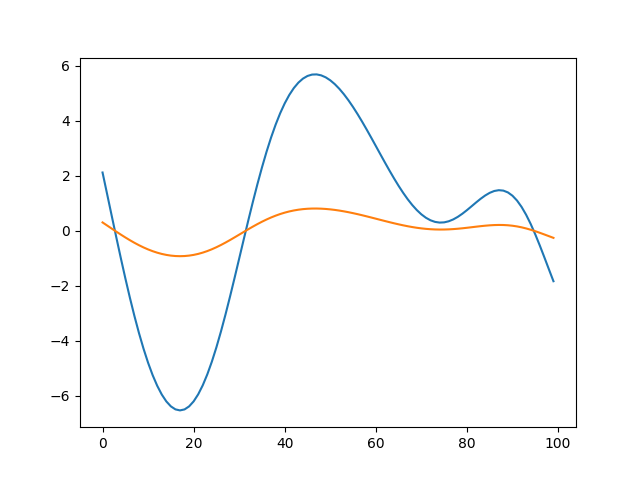

In [3]:
plt.plot(var1[0:100])
plt.plot(var1_norm[0:100])
plt.show()

In [4]:
#Architecture & Hyperparameters
layer_in = 4
layer1 = 10
layer_out = 1
alpha = 0.01

In [5]:
# Subset Samples for training, validation
np.random.seed(1)

# Construct the proper lengths for the input and output
epochs = 20000
x_all = np.empty(shape=(epochs, layer_in))
y_all = np.empty(shape=(epochs, layer_out))
for i in xrange(epochs):
    x_all[i, :] = var1_norm[i:i+layer_in]
    y_all[i, :] = var1_norm[i+layer_in:i+layer_in+layer_out]


# For now, choose first few for training, later it's better to choose a random sample
train_examples = 10000
x_train = x_all[0:train_examples,:]
y_train = y_all[0:train_examples,:]

In [6]:
def sigmoid(x, deriv=False):
    if deriv:
        return x * (1 - x)
    else:
        return 1 / (1 + np.exp(-x))

In [7]:
np.random.seed(1)
#Input -> l1 Weight matrix has to be np.shape = (6, 20) extra bias term
w1 = 2*np.random.random((layer_in + 1, layer1)) - 1

#l1 -> Output Weight matrix has to be np.shape = (21, 4) extra bias term
w2 = 2*np.random.random((layer1 + 1, layer_out)) - 1

epoch_size = 1
train_idx = np.random.randint(0, train_examples, size=(epoch_size))
x0 = np.hstack((np.ones((epoch_size,1)), x_train[train_idx,:]))
y = y_train[train_idx,:] # matrix shape (4,n)

x1 = np.hstack((np.ones((epoch_size,1)), sigmoid(w1.T.dot(x0.T)).T)) # vector length 201
x2 = sigmoid(w2.T.dot(x1.T)).T # vector length 10

tot_error = sum(sum((x2 - y)**2 / (2 * epoch_size)))
l2_delta = sigmoid(x2, True)*(x2 - y) # matrix shape (10,n)
l1_delta = sigmoid(x1[:,1:], True)*(w2[1:,:].dot(l2_delta.T).T)

l2_grad = l2_delta[:, :, np.newaxis].T * x1[:, np.newaxis, :].T
l1_grad = l1_delta[:, :, np.newaxis].T * x0[:, np.newaxis, :].T

l2_totgrad = np.average(l2_grad, axis=2) # matrix shape (101,10)
l1_totgrad = np.average(l1_grad, axis=2) # matrix shape (785,200)

w2 += -alpha*l2_totgrad # update weight 2 -> 3
w1 += -alpha*l1_totgrad # update weight 1 -> 2


In [36]:
np.random.seed(1)
#Input -> l1 Weight matrix has to be np.shape = (6, 20) extra bias term
w1 = 2*np.random.random((layer_in + 1, layer1)) - 1

#l1 -> Output Weight matrix has to be np.shape = (21, 4) extra bias term
w2 = 2*np.random.random((layer1 + 1, layer_out)) - 1
#Training
tot_error = 1
counter = 0

tstart = time.time()
iterations = 10000
# epoch_size controls how many examples the training algorithm uses each time
epoch_size = 10
while (counter < iterations):

    # randomize which part of the training set we use
    train_idx = np.random.randint(0, train_examples, size=(epoch_size))
    
    # forward prop
    # load in input & label
    x0 = np.hstack((np.ones((epoch_size,1)), x_train[train_idx,:]))
    y = y_train[train_idx,:] 
    
    # propagate forward 
    x1 = np.hstack((np.ones((epoch_size,1)), sigmoid(w1.T.dot(x0.T)).T)) # vector length 201
    x2 = w2.T.dot(x1.T).T # vector length 10

    # backprop
    # calculate errors
    tot_error = sum(sum((x2 - y)**2 / (2 * epoch_size)))
    l2_delta = (x2 - y) # matrix shape (10,n)
    l1_delta = sigmoid(x1[:,1:], True)*(w2[1:,:].dot(l2_delta.T).T)
    
    # calculate gradients
    l2_grad = l2_delta[:, :, np.newaxis].T * x1[:, np.newaxis, :].T
    l1_grad = l1_delta[:, :, np.newaxis].T * x0[:, np.newaxis, :].T
    
    # find total gradient across all examples
    l2_totgrad = np.average(l2_grad, axis=2) # matrix shape (101,10)
    l1_totgrad = np.average(l1_grad, axis=2) # matrix shape (785,200)
    
    if counter % 1000 == 0:
        print ("Iteration %d, Error: %f" % (counter, tot_error))
    counter += 1
        
    # update weights
    w2 += -alpha*l2_totgrad/np.sqrt(counter) # update weight 2 -> 3
    w1 += -alpha*l1_totgrad/np.sqrt(counter) # update weight 1 -> 2
        
print ("Training to %f error rate took %d seconds." % (tot_error, time.time()-tstart))

Iteration 0, Error: 1.544015
Iteration 1000, Error: 0.143078
Iteration 2000, Error: 0.116887
Iteration 3000, Error: 0.082857
Iteration 4000, Error: 0.031260
Iteration 5000, Error: 0.075464
Iteration 6000, Error: 0.081170
Iteration 7000, Error: 0.071210
Iteration 8000, Error: 0.039798
Iteration 9000, Error: 0.039918
Training to 0.053348 error rate took 2 seconds.


In [37]:
# Validation
def validate():
    # might be a crude way of defining our validation set
    epoch_size = epochs - train_examples
    val_idx = np.random.randint(train_examples, epochs, size=(epoch_size))
    
    x0 = np.hstack((np.ones((epoch_size,1)), x_all[val_idx,:]))
    y = y_all[val_idx,:] 
    
    # propagate forward 
    x1 = np.hstack((np.ones((epoch_size,1)), sigmoid(w1.T.dot(x0.T)).T)) # vector length 201
    x2 = sigmoid(w2.T.dot(x1.T)).T # vector length 10

    # backprop
    # calculate errors
    tot_error = sum(sum((x2 - y)**2 / (2 * epoch_size)))
    return tot_error

In [38]:
validate()

0.19402827151444635

In [39]:
def predict(t_start, time_steps):
    x_true = var1_norm[t_start:t_start + time_steps]
    x_predict = np.empty(shape=(time_steps))
    for i in range(time_steps):
        if i == 0:
            x0 = np.hstack(([1], var1_norm[t_start - layer_in:t_start]))
        elif (i < layer_in):
            x0 = np.hstack(([1], x0[2:layer_in - i + 2], x_predict[0:i] ))
        else:
            x0 = np.hstack(([1], x_predict[i-layer_in:i]))
            
        
        #for testing:
        x0 = np.hstack(([1], var1_norm[t_start+i:t_start+i+layer_in]))
        
        x1 = np.hstack(([1], sigmoid(w1.T.dot(x0.T)).T))
        x2 = w2.T.dot(x1.T).T # vector length 10
        x_predict[i] = x2[0]
    print("Root mean square error: %f" % (np.sqrt(sum(x_predict - x_true)**2) / time_steps))
    return(x_true, x_predict)


In [40]:
true, prediction = predict(333,2000)
# print(true)
#print(prediction)

Root mean square error: 0.016183


<IPython.core.display.Javascript object>


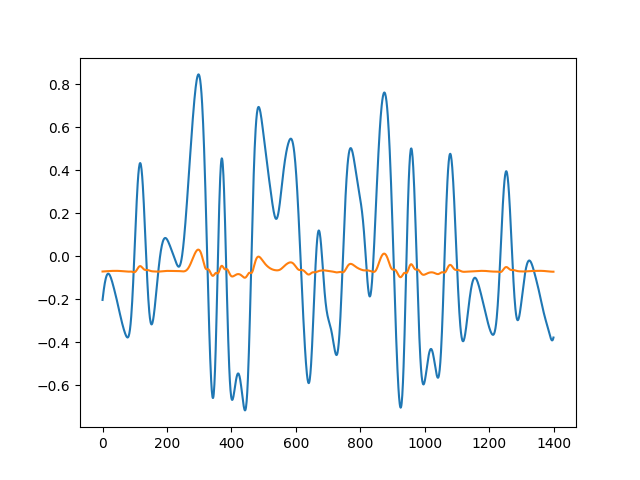

In [41]:
window = np.arange(0,int(0.7*prediction.size))
plt.plot(true[window])
plt.plot(prediction[window])
plt.show()